In [5]:
from datasets import load_dataset
from dataloader import *
from transformer import *
import pandas as pd
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
from copy import deepcopy

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [26]:
def validation(model, iterator, criterion, device):
    # set model into evaluation mode
    model.eval()

    # validation
    # loss, metrics for current epoch
    val_epoch_loss = 0
    val_epoch_accuracy = 0

    with torch.no_grad(): # stop graph
        # batches
        for i, batch in enumerate(iterator):
            src = batch[0] # X
            trg = batch[1] # y
            src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
            output = model(src)
            y_pred = torch.argmax(output, dim=-1) # logits -> labels
            output_reshape = output.contiguous().view(-1, output.shape[-1])
            trg = trg.to(torch.int64)

            loss = criterion(output_reshape, trg) # calculate loss
            agreements = torch.eq(y_pred, trg)
            accuracy = torch.mean(agreements.double()) # calculate accuracy

            val_epoch_loss += loss.item()
            val_epoch_accuracy += accuracy

    # return mean loss w.r.t. batches
    return val_epoch_loss / len(iterator), val_epoch_accuracy / len(iterator)

def plot_training(history, marker=None):
    # put everything on cpu
    for key, value in history.items():
        history[key] = [element.cpu() if isinstance(element, torch.Tensor) else element for element in value]

    plt.subplots_adjust(left=0.1,
                    bottom=0.01,
                    right=1.5,
                    top=0.6,
                    wspace=0.4,
                    hspace=0.4)

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'])
    plt.plot(history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.title('Training loss')

    # vertical line for marking best epoch
    if marker is not None:
        y_min = min(history['train_loss'] + history['val_loss'])
        y_max = max(history['train_loss'] + history['val_loss'])
        plt.vlines(x=marker, ymin=y_min, ymax=y_max, color='red')

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'])
    plt.plot(history['val_acc'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.title('Training metric')

    # vertical line for marking best epoch
    if marker is not None:
        y_min = min(history['train_acc'] + history['val_acc'])
        y_max = max(history['train_acc'] + history['val_acc'])
        plt.vlines(x=marker, ymin=y_min, ymax=y_max, color='red')

    plt.show()

def train_save_best(model, iterator, valid_iter, optimizer, criterion, epoch, clip, device):

    # set model into training mode
    model.train()

    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5)

    # save data - init
    history = {'train_loss': [],
               'val_loss': [],
               'train_acc': [],
               'val_acc': [],
               'learning_rate': []}
    best_model = None
    best_model_score = 1e9
    best_model_epoch = 0

    # training
    for e in range(epoch):
        # loss, metrics for current epoch
        epoch_loss = 0
        epoch_acc = 0

        # batches
        for i, batch in enumerate(tqdm(iterator)):
            src = batch[0] # X
            trg = batch[1] # y
            src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
            optimizer.zero_grad() # reset optimizer
            output = model(src) # predict
            y_pred = torch.argmax(output, dim=-1) # logits -> labels
            output_reshape = output.contiguous().view(-1, output.shape[-1])
            trg = trg.to(torch.int64)
            loss = criterion(output_reshape, trg) # calculate loss
            agreements = torch.eq(y_pred, trg)
            accuracy = torch.mean(agreements.double()) # calculate accuracy
            loss.backward() # backward pass

            epoch_loss += loss.item()
            epoch_acc += accuracy / len(iterator)

            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step() # optimize model

        # validation
        val_loss, val_acc = validation(model, valid_iter, criterion, device)
        
        scheduler.step(val_loss)

        # save data
        with torch.no_grad():
            current_lr = optimizer.param_groups[0]['lr']

            for key, value in zip(history.keys(), [epoch_loss / len(iterator), val_loss, epoch_acc, val_acc, current_lr]):
                history[key].append(value)

            # save best model (w.r.t validation loss)
            if val_loss < best_model_score:
                best_model = model.state_dict()
                best_model_score = val_loss
                best_model_epoch = e

        # visualization
        print(f"Epoch: {e + 1}  Train Loss: {epoch_loss / len(iterator):.4f} \
              Validation Loss: {val_loss:.4f} \
              Train acc: {epoch_acc:.4f}, \
              Val acc: {val_acc:.4f}, \
              Learning Rate : {optimizer.param_groups[0]['lr'] :.4f}")

    # print training curve
    plot_training(history, marker=best_model_epoch)

    return history, best_model, best_model_score


## Import Data

In [8]:
# init
tokenizer = Tokenizer()
loader = DataLoader(tokenize = tokenizer.tokenize)

dataset = load_dataset("sentiment140")
data_train = pd.DataFrame({'text': dataset['train']['text'], 'sentiment' : dataset['train']['sentiment']})
data_test = pd.DataFrame({'text': dataset['test']['text'], 'sentiment' : dataset['test']['sentiment']})

concat = [data_train, data_test]
data = pd.concat(concat)
data = data.sample(n = 70000, random_state = 42)
# convert string label to binary (int) label (positive:1, negative:0)
data["sentiment"] = data['sentiment'].apply(lambda x : int(x == 4))
# train, test, val split
train_A, valid_A, test_A = loader.make_dataset(data)

dataset = load_dataset("sst2")

data_train = pd.DataFrame({'text': dataset['train']['sentence'], 'sentiment' : dataset['train']['label']})
data_test = pd.DataFrame({'text': dataset['test']['sentence'], 'sentiment' : dataset['test']['label']})
data_val = pd.DataFrame({'text': dataset['validation']['sentence'], 'sentiment' : dataset['validation']['label']})

concat = [data_train, data_test, data_val]
data = pd.concat(concat)
data = data.sample(n = len(data), random_state = 42)
# convert string label to binary (int) label (positive:1, negative:0)
data["sentiment"] = data['sentiment'].apply(lambda x : int(x == 1))
# train, test, val split
train_B, valid_B, test_B = loader.make_dataset(data)

vocab = loader.get_vocab(pd.concat([train_A, train_B], ignore_index=True).iloc[:, 0])

train_iter_A, valid_iter_A, test_iter_A = loader.make_iter(train_A, valid_A, test_A,
                                                     batch_size=512,
                                                     device=device,
                                                     vocab=vocab)

train_iter_B, valid_iter_B, test_iter_B = loader.make_iter(train_B, valid_B, test_B,
                                                     batch_size=512,
                                                     device=device,
                                                     vocab=vocab)

# NLP stuff
pad_idx = vocab['__PAD__']
voc_size = len(vocab)
print("Vocabulary Size : ", voc_size)

dataset initializing start


Found cached dataset sentiment140 (C:/Users/atace/.cache/huggingface/datasets/sentiment140/sentiment140/1.0.0/f81c014152931b776735658d8ae493b181927de002e706c4d5244ecb26376997)
100%|██████████| 2/2 [00:00<00:00, 28.24it/s]


Length of data after first step of preprocessing:  70000
Tokenizing the data...
Length of the data :  70000
1


Found cached dataset sst2 (C:/Users/atace/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5)
100%|██████████| 3/3 [00:00<00:00, 426.70it/s]


Length of data after first step of preprocessing:  70042
Tokenizing the data...
Length of the data :  70042
1
text         [[CLS], wicked, ##bit, ##ch, it, is, because, ...
sentiment                                                    1
len                                                         15
Name: 1102814, dtype: object


100%|██████████| 7000/7000 [00:00<00:00, 12026.80it/s]


dataset initializing done
text         [[CLS], elegant, ##ly, appointed, [SEP]]
sentiment                                           1
len                                                 5
Name: 60611, dtype: object


100%|██████████| 7005/7005 [00:00<00:00, 14685.70it/s]


dataset initializing done
Vocabulary Size :  20369


In [13]:
# Creating the embedding matrix
embeddingA = torch.nn.Embedding(voc_size, 16)

  0%|          | 0/110 [00:00<?, ?it/s]C:\Users\atace\AppData\Local\Temp/ipykernel_7292/1208177187.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
100%|██████████| 110/110 [05:19<00:00,  2.91s/it]
C:\Users\atace\AppData\Local\Temp/ipykernel_7292/1208177187.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu


Epoch: 1  Train Loss: 0.8094               Validation Loss: 0.7351               Train acc: 0.5010,               Val acc: 0.4897,               Learning Rate : 0.0010


100%|██████████| 110/110 [05:24<00:00,  2.95s/it]


Epoch: 2  Train Loss: 0.7196               Validation Loss: 0.7101               Train acc: 0.5017,               Val acc: 0.4944,               Learning Rate : 0.0010


100%|██████████| 110/110 [04:09<00:00,  2.27s/it]


Epoch: 3  Train Loss: 0.7116               Validation Loss: 0.6874               Train acc: 0.5372,               Val acc: 0.5530,               Learning Rate : 0.0010


100%|██████████| 110/110 [04:18<00:00,  2.35s/it]


Epoch: 4  Train Loss: 0.6663               Validation Loss: 0.6488               Train acc: 0.5905,               Val acc: 0.6273,               Learning Rate : 0.0010


100%|██████████| 110/110 [04:24<00:00,  2.41s/it]


Epoch: 5  Train Loss: 0.6326               Validation Loss: 0.6178               Train acc: 0.6436,               Val acc: 0.6676,               Learning Rate : 0.0010


100%|██████████| 110/110 [03:54<00:00,  2.13s/it]


Epoch: 6  Train Loss: 0.6087               Validation Loss: 0.6606               Train acc: 0.6716,               Val acc: 0.6283,               Learning Rate : 0.0010


100%|██████████| 110/110 [03:55<00:00,  2.14s/it]


Epoch: 7  Train Loss: 0.5771               Validation Loss: 0.5773               Train acc: 0.7028,               Val acc: 0.7047,               Learning Rate : 0.0010


100%|██████████| 110/110 [04:01<00:00,  2.19s/it]


Epoch: 8  Train Loss: 0.5516               Validation Loss: 0.5646               Train acc: 0.7230,               Val acc: 0.7152,               Learning Rate : 0.0010


100%|██████████| 110/110 [03:53<00:00,  2.12s/it]


Epoch: 9  Train Loss: 0.5211               Validation Loss: 0.5522               Train acc: 0.7488,               Val acc: 0.7268,               Learning Rate : 0.0010


100%|██████████| 110/110 [04:00<00:00,  2.18s/it]


Epoch: 10  Train Loss: 0.5028               Validation Loss: 0.5503               Train acc: 0.7617,               Val acc: 0.7326,               Learning Rate : 0.0010


100%|██████████| 110/110 [04:36<00:00,  2.51s/it]


Epoch: 11  Train Loss: 0.4777               Validation Loss: 0.5334               Train acc: 0.7778,               Val acc: 0.7424,               Learning Rate : 0.0010


100%|██████████| 110/110 [04:17<00:00,  2.34s/it]


Epoch: 12  Train Loss: 0.4569               Validation Loss: 0.5260               Train acc: 0.7886,               Val acc: 0.7462,               Learning Rate : 0.0010


100%|██████████| 110/110 [03:51<00:00,  2.10s/it]


Epoch: 13  Train Loss: 0.4442               Validation Loss: 0.5236               Train acc: 0.7964,               Val acc: 0.7506,               Learning Rate : 0.0010


100%|██████████| 110/110 [04:15<00:00,  2.33s/it]


Epoch: 14  Train Loss: 0.4310               Validation Loss: 0.5240               Train acc: 0.8048,               Val acc: 0.7551,               Learning Rate : 0.0010


100%|██████████| 110/110 [04:03<00:00,  2.21s/it]


Epoch: 15  Train Loss: 0.4202               Validation Loss: 0.5298               Train acc: 0.8100,               Val acc: 0.7481,               Learning Rate : 0.0010


100%|██████████| 110/110 [04:17<00:00,  2.34s/it]


Epoch: 16  Train Loss: 0.4084               Validation Loss: 0.5415               Train acc: 0.8177,               Val acc: 0.7420,               Learning Rate : 0.0010


100%|██████████| 110/110 [05:05<00:00,  2.78s/it]


Epoch: 17  Train Loss: 0.3991               Validation Loss: 0.5307               Train acc: 0.8231,               Val acc: 0.7508,               Learning Rate : 0.0010


100%|██████████| 110/110 [04:13<00:00,  2.30s/it]


Epoch: 18  Train Loss: 0.3924               Validation Loss: 0.5250               Train acc: 0.8253,               Val acc: 0.7583,               Learning Rate : 0.0010


100%|██████████| 110/110 [04:11<00:00,  2.28s/it]


Epoch: 19  Train Loss: 0.3829               Validation Loss: 0.5358               Train acc: 0.8314,               Val acc: 0.7608,               Learning Rate : 0.0001


100%|██████████| 110/110 [03:54<00:00,  2.13s/it]


Epoch: 20  Train Loss: 0.3687               Validation Loss: 0.5339               Train acc: 0.8387,               Val acc: 0.7585,               Learning Rate : 0.0001


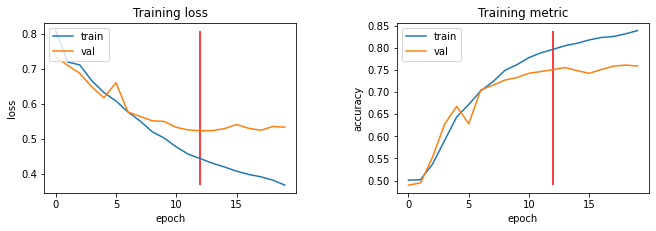

Wall time: 1h 31min 31s


In [14]:
%%time
# train model A
modelA = TransformerClassifier(embedding=embeddingA,
                              src_pad_idx = pad_idx,
                              enc_voc_size = voc_size,
                              max_len = 256,
                              d_model = 16,
                              ffn_hidden = 32,
                              n_head = 2,
                              n_layers = 1,
                              drop_prob = 0.7,
                              device = device)
modelA = modelA.to(device) # put on CPU/GPU

optA = torch.optim.Adam(modelA.parameters(), lr=0.001)
loss_fnA = nn.CrossEntropyLoss()


epochs = 20

historyA, best_modelA, best_model_scoreA = train_save_best(model=modelA,
                                                            iterator=train_iter_A,
                                                            valid_iter=valid_iter_A,
                                                            optimizer=optA,
                                                            criterion=loss_fnA,
                                                            epoch=epochs,
                                                            clip=1,
                                                            device=device)

# save model
torch.save(best_modelA, './Models/modelA_sentiment140_256')

# save history
with open('./Models/history_modelA_sentiment140_256.txt', 'w') as dat:
    dat.write(str(historyA))

In [15]:
torch.save(embeddingA, "Models\embeddingA_16_trained_downstream.pt")

In [27]:
embeddingB = deepcopy(embeddingA)

  0%|          | 0/110 [00:00<?, ?it/s]C:\Users\atace\AppData\Local\Temp/ipykernel_7292/3571779913.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
100%|██████████| 110/110 [05:01<00:00,  2.74s/it]
C:\Users\atace\AppData\Local\Temp/ipykernel_7292/3571779913.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu


Epoch: 1  Train Loss: 0.8066               Validation Loss: 0.7147               Train acc: 0.5112,               Val acc: 0.5351,               Learning Rate : 0.0010


100%|██████████| 110/110 [04:33<00:00,  2.49s/it]


Epoch: 2  Train Loss: 0.6939               Validation Loss: 0.6404               Train acc: 0.5619,               Val acc: 0.6368,               Learning Rate : 0.0010


100%|██████████| 110/110 [04:02<00:00,  2.20s/it]


Epoch: 3  Train Loss: 0.6228               Validation Loss: 0.5935               Train acc: 0.6523,               Val acc: 0.6768,               Learning Rate : 0.0010


100%|██████████| 110/110 [04:01<00:00,  2.19s/it]


Epoch: 4  Train Loss: 0.5538               Validation Loss: 0.5364               Train acc: 0.7191,               Val acc: 0.7456,               Learning Rate : 0.0010


100%|██████████| 110/110 [04:27<00:00,  2.43s/it]


Epoch: 5  Train Loss: 0.5167               Validation Loss: 0.5311               Train acc: 0.7476,               Val acc: 0.7403,               Learning Rate : 0.0010


100%|██████████| 110/110 [04:20<00:00,  2.37s/it]


Epoch: 6  Train Loss: 0.4772               Validation Loss: 0.5530               Train acc: 0.7767,               Val acc: 0.7286,               Learning Rate : 0.0010


100%|██████████| 110/110 [04:13<00:00,  2.30s/it]


Epoch: 7  Train Loss: 0.4385               Validation Loss: 0.4529               Train acc: 0.8036,               Val acc: 0.7969,               Learning Rate : 0.0010


100%|██████████| 110/110 [04:03<00:00,  2.21s/it]


Epoch: 8  Train Loss: 0.3951               Validation Loss: 0.4067               Train acc: 0.8278,               Val acc: 0.8294,               Learning Rate : 0.0010


100%|██████████| 110/110 [03:55<00:00,  2.14s/it]


Epoch: 9  Train Loss: 0.3699               Validation Loss: 0.4035               Train acc: 0.8416,               Val acc: 0.8248,               Learning Rate : 0.0010


100%|██████████| 110/110 [03:54<00:00,  2.13s/it]


Epoch: 10  Train Loss: 0.3486               Validation Loss: 0.3962               Train acc: 0.8542,               Val acc: 0.8320,               Learning Rate : 0.0010


100%|██████████| 110/110 [04:03<00:00,  2.21s/it]


Epoch: 11  Train Loss: 0.3167               Validation Loss: 0.3784               Train acc: 0.8699,               Val acc: 0.8409,               Learning Rate : 0.0010


100%|██████████| 110/110 [04:58<00:00,  2.71s/it]


Epoch: 12  Train Loss: 0.3010               Validation Loss: 0.3703               Train acc: 0.8787,               Val acc: 0.8475,               Learning Rate : 0.0010


100%|██████████| 110/110 [04:58<00:00,  2.72s/it]


Epoch: 13  Train Loss: 0.2888               Validation Loss: 0.3881               Train acc: 0.8842,               Val acc: 0.8409,               Learning Rate : 0.0010


100%|██████████| 110/110 [04:59<00:00,  2.73s/it]


Epoch: 14  Train Loss: 0.2677               Validation Loss: 0.3458               Train acc: 0.8947,               Val acc: 0.8636,               Learning Rate : 0.0010


100%|██████████| 110/110 [05:02<00:00,  2.75s/it]


Epoch: 15  Train Loss: 0.2558               Validation Loss: 0.3423               Train acc: 0.9008,               Val acc: 0.8662,               Learning Rate : 0.0010


100%|██████████| 110/110 [04:21<00:00,  2.38s/it]


Epoch: 16  Train Loss: 0.2427               Validation Loss: 0.3339               Train acc: 0.9065,               Val acc: 0.8742,               Learning Rate : 0.0010


100%|██████████| 110/110 [05:31<00:00,  3.01s/it]


Epoch: 17  Train Loss: 0.2356               Validation Loss: 0.3333               Train acc: 0.9100,               Val acc: 0.8781,               Learning Rate : 0.0010


100%|██████████| 110/110 [05:06<00:00,  2.78s/it]


Epoch: 18  Train Loss: 0.2233               Validation Loss: 0.3306               Train acc: 0.9148,               Val acc: 0.8794,               Learning Rate : 0.0010


100%|██████████| 110/110 [04:17<00:00,  2.34s/it]


Epoch: 19  Train Loss: 0.2148               Validation Loss: 0.3322               Train acc: 0.9200,               Val acc: 0.8797,               Learning Rate : 0.0010


100%|██████████| 110/110 [04:18<00:00,  2.35s/it]


Epoch: 20  Train Loss: 0.2077               Validation Loss: 0.3339               Train acc: 0.9229,               Val acc: 0.8828,               Learning Rate : 0.0010


100%|██████████| 110/110 [04:07<00:00,  2.25s/it]


Epoch: 21  Train Loss: 0.1995               Validation Loss: 0.3385               Train acc: 0.9267,               Val acc: 0.8775,               Learning Rate : 0.0010


100%|██████████| 110/110 [04:07<00:00,  2.25s/it]


Epoch: 22  Train Loss: 0.1936               Validation Loss: 0.3366               Train acc: 0.9281,               Val acc: 0.8853,               Learning Rate : 0.0010


100%|██████████| 110/110 [04:17<00:00,  2.34s/it]


Epoch: 23  Train Loss: 0.1852               Validation Loss: 0.3419               Train acc: 0.9324,               Val acc: 0.8843,               Learning Rate : 0.0010


100%|██████████| 110/110 [03:55<00:00,  2.14s/it]


Epoch: 24  Train Loss: 0.1795               Validation Loss: 0.3404               Train acc: 0.9349,               Val acc: 0.8854,               Learning Rate : 0.0001


100%|██████████| 110/110 [04:01<00:00,  2.20s/it]


Epoch: 25  Train Loss: 0.1689               Validation Loss: 0.3383               Train acc: 0.9399,               Val acc: 0.8874,               Learning Rate : 0.0001


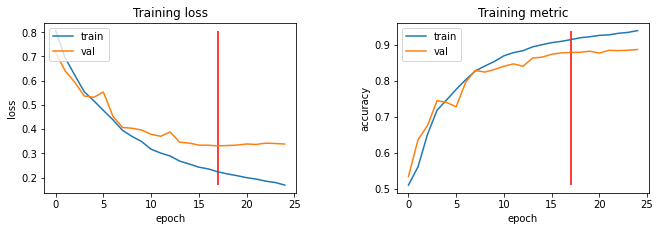

Wall time: 1h 57min 25s


In [28]:
%%time
# train model B
modelB = TransformerClassifier(embedding=embeddingB,
                              src_pad_idx = pad_idx,
                              enc_voc_size = voc_size,
                              max_len = 256,
                              d_model = 16,
                              ffn_hidden = 32,
                              n_head = 2,
                              n_layers = 1,
                              drop_prob = 0.7,
                              device = device)
modelB = modelB.to(device) # put on CPU/GPU

optB = torch.optim.Adam(modelB.parameters(), lr=0.001)
loss_fnB = nn.CrossEntropyLoss()


epochs = 25

historyB, best_modelB, best_model_scoreB = train_save_best(model=modelB,
                                                            iterator=train_iter_B,
                                                            valid_iter=valid_iter_B,
                                                            optimizer=optB,
                                                            criterion=loss_fnB,
                                                            epoch=epochs,
                                                            clip=1,
                                                            device=device)

# save model
torch.save(best_modelB, './Models/modelB_sst2_256')

# save history
with open('./Models/history_modelB_sst2_256.txt', 'w') as dat:
    dat.write(str(historyB))

In [29]:
torch.save(embeddingB, "Models\embeddingB_16_trained_downstream.pt")

In [30]:
# Test the models on the sentiment140 test set
criterion = torch.nn.CrossEntropyLoss()

test_loss_A, test_acc_A = validation(modelA, test_iter_A, criterion, device)
test_loss_B, test_acc_B = validation(modelB, test_iter_A, criterion, device)

print("Test Loss Model A:     ", test_loss_A)
print("Test Accuracy Model A:     ", test_acc_A.item())
print("Test Loss Model B:     ", test_loss_B)
print("Test Accuracy Model B:     ", test_acc_B.item())

C:\Users\atace\AppData\Local\Temp/ipykernel_7292/3571779913.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu


Test Loss Model A:      0.518511244228908
Test Accuracy Model A:      0.7642201775332226
Test Loss Model B:      1.1635120681353979
Test Accuracy Model B:      0.6583815666528239


In [31]:
# Test the models on the Stanford Treebank test set
criterion = torch.nn.CrossEntropyLoss()

test_loss_A, test_acc_A = validation(modelA, test_iter_B, criterion, device)
test_loss_B, test_acc_B = validation(modelB, test_iter_B, criterion, device)

print("Test Loss Model A:     ", test_loss_A)
print("Test Accuracy Model A:     ", test_acc_A.item())
print("Test Loss Model B:     ", test_loss_B)
print("Test Accuracy Model B:     ", test_acc_B.item())

C:\Users\atace\AppData\Local\Temp/ipykernel_7292/3571779913.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu


Test Loss Model A:      0.7928882965019771
Test Accuracy Model A:      0.6236352908821122
Test Loss Model B:      0.36487063339778353
Test Accuracy Model B:      0.8753877468788376
